In [ ]:
import torch
from collections import OrderedDict

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pgf.texsystem'] = 'pdflatex'
matplotlib.rcParams.update({'font.family': 'serif', 'font.size': 10})
matplotlib.rcParams['text.usetex'] = True
from matplotlib.lines import Line2D

from scipy.interpolate import griddata
import time

np.random.seed(1234)

In [ ]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

As a proof of concept of divide and conquer phyiscs informed neural networks, we consider the ODE

\begin{align*}
    \frac{d}{dt} \begin{pmatrix} y_1 \\ y_2 \end{pmatrix}(t) = \begin{pmatrix} -y_2 \\ y_1 \end{pmatrix} (t).
\end{align*}

For a given initial state $y_0 = (y_0^1, y_0^2) \in \mathbb{R}^2$, the solution $(y(t))_{t\geq0}$ flows in counter clockwise circles and is given by

\begin{align*}
    y(t) = \begin{pmatrix} y_0^1 \cos(t) - y_0^2 \sin(t) \\ y_0^2 \cos(t) + y_0^1 \sin(t) \end{pmatrix}.
\end{align*}

In [ ]:
def vector_field(y):
    
    return torch.tensor([-y[1], y[0]])


def solution_simple_ODE(t, y0):
    
    y1t = y0[0] * np.cos(t) - y0[1] * np.sin(t)
    y2t = y0[1] * np.cos(t) + y0[0] * np.sin(t)

    return np.array([y1t, y2t])

In [ ]:
# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [ ]:
# the deep neural network

class DNN(torch.nn.Module):
    
    def __init__(self, layers):
        
        super().__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        # set up layer order dict
        self.activation = torch.nn.Tanh
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation()))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)
    
    
    def forward(self, x):
        
        # x = (t, y0)
        return self.layers(x)


In [ ]:
class PINN_baseline():

    def __init__(self, X_pinn, X_semigroup, X_smooth, T,nas_model,layers,nas_search = True):

        # neural network architecture
        self.layers = layers
        self.dnn = DNN(layers).to(device)
        
        #self.dnn = nas_model.to(device)
        # semigroup PINN step time
        self.T = torch.tensor(T).float().to(device)

        # training data
        self.t_pinn = torch.tensor(X_pinn[:, :1], requires_grad=True).float().to(device)
        self.y_pinn = torch.tensor(X_pinn[:, 1:], requires_grad=True).float().to(device)
        
        self.s_semigroup = torch.tensor(X_semigroup[:, :1], requires_grad=True).float().to(device)
        self.t_semigroup = torch.tensor(X_semigroup[:, 1:2], requires_grad=True).float().to(device)
        self.y_semigroup = torch.tensor(X_semigroup[:, 2:], requires_grad=True).float().to(device)
        
        self.t_smooth = torch.tensor(X_smooth[:, :1], requires_grad=True).float().to(device)
        self.y_smooth = torch.tensor(X_smooth[:, 1:], requires_grad=True).float().to(device)
        
        # optimization
        #low fidelity evaluation for NAS search
        if nas_search:
          self.optimizer = torch.optim.LBFGS(
              self.dnn.parameters(), lr=1.0, max_iter=100, max_eval=100, 
              history_size=50, tolerance_grad=1e-5, tolerance_change=np.finfo(float).eps, 
              line_search_fn="strong_wolfe"
          )
        #Train after picking the best architecture
        else:
          self.optimizer = torch.optim.LBFGS(
              self.dnn.parameters(), lr=1.0, max_iter=2000, max_eval=2000, 
              history_size=50, tolerance_grad=1e-5, tolerance_change=np.finfo(float).eps, 
              line_search_fn="strong_wolfe"
          )

        self.iter = 0
    
    
    def net_y(self, t, y0):
        
        # The M(t, y0) = y0 + t N(t, y0) scheme seems to drastically increase the accuracy
        # This works perfectly fine with automatic differentiation
        y = y0 + t * self.dnn(torch.cat([t, y0], dim=1))
        
        return y
    
    
    def net_derivative(self, t, y0):
        """
        Pytorch automatic differentiation to compute the derivative of the neural network
        """
        y = self.net_y(t, y0)
        
        # vectors for the autograd vector Jacobian product 
        # to compute the derivatives w.r.t. every output dimension
        vectors = [torch.zeros_like(y) for i in range(2)]
        
        for i, vec in enumerate(vectors):
            
            vec[:,i] = 1.
        
        # list of derivative tensors
        # the first entry is a tensor with \partial_t PINN(t, y0) for all (t, y0) in the batch,
        # each input (t, y0) corresponds to one row in each tensor
        derivatives = [
            torch.autograd.grad(
                y, t, 
                grad_outputs=vec,
                retain_graph=True,
                create_graph=True
            )[0]
            for vec in vectors
        ]
        
        return derivatives
    
    
    def loss_function(self):
        
        self.optimizer.zero_grad()
        
        y_pred = self.net_y(self.t_pinn, self.y_pinn)
        deriv_pred = self.net_derivative(self.t_pinn, self.y_pinn)
        
        # This is specific to the ODE
        loss_pinn1 = torch.mean((deriv_pred[0] + y_pred[:,1:2]) ** 2)
        loss_pinn2 = torch.mean((deriv_pred[1] - y_pred[:,0:1]) ** 2)
        loss_pinn = loss_pinn1 + loss_pinn2
        
        # The general semigroup loss for autonomous ODEs
        y_pred_tps = self.net_y(self.s_semigroup + self.t_semigroup, self.y_semigroup)
        y_pred_s = self.net_y(self.s_semigroup, self.y_semigroup)
        y_pred_restart = self.net_y(self.t_semigroup, y_pred_s)
        loss_semigroup = torch.mean((y_pred_tps - y_pred_restart) ** 2)
        
        # The smoothness loss
        y_pred_smooth = self.net_y(self.t_smooth, self.y_smooth)
        deriv_pred_below = self.net_derivative(self.t_smooth, self.y_smooth)
        deriv_pred_above = self.net_derivative(torch.zeros_like(self.t_smooth, requires_grad=True), y_pred_smooth)
        
        loss_smooth = .0
        
        for t1, t2 in zip(deriv_pred_below, deriv_pred_above):
            
            loss_smooth += torch.mean((t1 - t2) ** 2)
        
        loss = loss_pinn + loss_smooth + loss_semigroup
        
        loss.backward()
        self.iter += 1
        
        if self.iter % 100 == 0:
            print(
                f"Iter {self.iter}, Loss: {loss.item():.5f}, Loss_pinn: {loss_pinn.item():.5f} " \
                f"Loss_smooth: {loss_smooth.item():.5f}, Loss_semigroup: {loss_semigroup.item():.5f}"
            )
        
        return loss
    
    def get_final_loss(self):
        self.optimizer.zero_grad()
        y_pred = self.net_y(self.t_pinn, self.y_pinn)
        deriv_pred = self.net_derivative(self.t_pinn, self.y_pinn)
        
        # This is specific to the ODE
        loss_pinn1 = torch.mean((deriv_pred[0] + y_pred[:,1:2]) ** 2)
        loss_pinn2 = torch.mean((deriv_pred[1] - y_pred[:,0:1]) ** 2)
        loss_pinn = loss_pinn1 + loss_pinn2
        
        # The general semigroup loss for autonomous ODEs
        y_pred_tps = self.net_y(self.s_semigroup + self.t_semigroup, self.y_semigroup)
        y_pred_s = self.net_y(self.s_semigroup, self.y_semigroup)
        y_pred_restart = self.net_y(self.t_semigroup, y_pred_s)
        loss_semigroup = torch.mean((y_pred_tps - y_pred_restart) ** 2)
        
        # The smoothness loss
        y_pred_smooth = self.net_y(self.t_smooth, self.y_smooth)
        deriv_pred_below = self.net_derivative(self.t_smooth, self.y_smooth)
        deriv_pred_above = self.net_derivative(torch.zeros_like(self.t_smooth, requires_grad=True), y_pred_smooth)
        
        loss_smooth = .0
        
        for t1, t2 in zip(deriv_pred_below, deriv_pred_above):
            
            loss_smooth += torch.mean((t1 - t2) ** 2)
        
        loss_final = loss_pinn + loss_smooth + loss_semigroup
        return loss_final

    def train(self):
        
        self.dnn.train()
        self.optimizer.step(self.loss_function)
        running_loss = self.get_final_loss()
        return running_loss.item()
        #self.dnn.train()
        #self.loss_function()
        #self.optimizer.step()
    
    def predict(self, t, y0):
        
        t = torch.tensor(t, requires_grad=True).float().to(device)
        y0 = torch.tensor(y0, requires_grad=True).float().to(device)
        
        self.dnn.eval()
        y = self.net_y(t, y0)
        y = y.detach().cpu().numpy()
        
        return y

In [ ]:
# PINN: physics-informed neural network
class PINN():

    def __init__(self, X_pinn, X_semigroup, X_smooth, T,nas_model,nas_search = True):

        # neural network architecture
        #self.layers = layers
        #self.dnn = DNN(layers).to(device)
        
        self.dnn = nas_model.to(device)
        # semigroup PINN step time
        self.T = torch.tensor(T).float().to(device)

        # training data
        self.t_pinn = torch.tensor(X_pinn[:, :1], requires_grad=True).float().to(device)
        self.y_pinn = torch.tensor(X_pinn[:, 1:], requires_grad=True).float().to(device)
        
        self.s_semigroup = torch.tensor(X_semigroup[:, :1], requires_grad=True).float().to(device)
        self.t_semigroup = torch.tensor(X_semigroup[:, 1:2], requires_grad=True).float().to(device)
        self.y_semigroup = torch.tensor(X_semigroup[:, 2:], requires_grad=True).float().to(device)
        
        self.t_smooth = torch.tensor(X_smooth[:, :1], requires_grad=True).float().to(device)
        self.y_smooth = torch.tensor(X_smooth[:, 1:], requires_grad=True).float().to(device)
        
        # optimization
        #low fidelity evaluation for NAS search
        if nas_search:
          self.optimizer = torch.optim.LBFGS(
              self.dnn.parameters(), lr=1.0, max_iter=100, max_eval=100, 
              history_size=50, tolerance_grad=1e-5, tolerance_change=np.finfo(float).eps, 
              line_search_fn="strong_wolfe"
          )
        #Train after picking the best architecture
        else:
          self.optimizer = torch.optim.LBFGS(
              self.dnn.parameters(), lr=1.0, max_iter=2000, max_eval=2000, 
              history_size=50, tolerance_grad=1e-5, tolerance_change=np.finfo(float).eps, 
              line_search_fn="strong_wolfe"
          )

        self.iter = 0
    
    
    def net_y(self, t, y0):
        
        # The M(t, y0) = y0 + t N(t, y0) scheme seems to drastically increase the accuracy
        # This works perfectly fine with automatic differentiation
        y = y0 + t * self.dnn(torch.cat([t, y0], dim=1))
        
        return y
    
    
    def net_derivative(self, t, y0):
        """
        Pytorch automatic differentiation to compute the derivative of the neural network
        """
        y = self.net_y(t, y0)
        
        # vectors for the autograd vector Jacobian product 
        # to compute the derivatives w.r.t. every output dimension
        vectors = [torch.zeros_like(y) for i in range(2)]
        
        for i, vec in enumerate(vectors):
            
            vec[:,i] = 1.
        
        # list of derivative tensors
        # the first entry is a tensor with \partial_t PINN(t, y0) for all (t, y0) in the batch,
        # each input (t, y0) corresponds to one row in each tensor
        derivatives = [
            torch.autograd.grad(
                y, t, 
                grad_outputs=vec,
                retain_graph=True,
                create_graph=True
            )[0]
            for vec in vectors
        ]
        
        return derivatives
    
    
    def loss_function(self):
        
        self.optimizer.zero_grad()
        
        y_pred = self.net_y(self.t_pinn, self.y_pinn)
        deriv_pred = self.net_derivative(self.t_pinn, self.y_pinn)
        
        # This is specific to the ODE
        loss_pinn1 = torch.mean((deriv_pred[0] + y_pred[:,1:2]) ** 2)
        loss_pinn2 = torch.mean((deriv_pred[1] - y_pred[:,0:1]) ** 2)
        loss_pinn = loss_pinn1 + loss_pinn2
        
        # The general semigroup loss for autonomous ODEs
        y_pred_tps = self.net_y(self.s_semigroup + self.t_semigroup, self.y_semigroup)
        y_pred_s = self.net_y(self.s_semigroup, self.y_semigroup)
        y_pred_restart = self.net_y(self.t_semigroup, y_pred_s)
        loss_semigroup = torch.mean((y_pred_tps - y_pred_restart) ** 2)
        
        # The smoothness loss
        y_pred_smooth = self.net_y(self.t_smooth, self.y_smooth)
        deriv_pred_below = self.net_derivative(self.t_smooth, self.y_smooth)
        deriv_pred_above = self.net_derivative(torch.zeros_like(self.t_smooth, requires_grad=True), y_pred_smooth)
        
        loss_smooth = .0
        
        for t1, t2 in zip(deriv_pred_below, deriv_pred_above):
            
            loss_smooth += torch.mean((t1 - t2) ** 2)
        
        loss = loss_pinn + loss_smooth + loss_semigroup
        
        loss.backward()
        self.iter += 1
        
        if self.iter % 100 == 0:
            print(
                f"Iter {self.iter}, Loss: {loss.item():.5f}, Loss_pinn: {loss_pinn.item():.5f} " \
                f"Loss_smooth: {loss_smooth.item():.5f}, Loss_semigroup: {loss_semigroup.item():.5f}"
            )
        
        return loss
    
    def get_final_loss(self):
        self.optimizer.zero_grad()
        y_pred = self.net_y(self.t_pinn, self.y_pinn)
        deriv_pred = self.net_derivative(self.t_pinn, self.y_pinn)
        
        # This is specific to the ODE
        loss_pinn1 = torch.mean((deriv_pred[0] + y_pred[:,1:2]) ** 2)
        loss_pinn2 = torch.mean((deriv_pred[1] - y_pred[:,0:1]) ** 2)
        loss_pinn = loss_pinn1 + loss_pinn2
        
        # The general semigroup loss for autonomous ODEs
        y_pred_tps = self.net_y(self.s_semigroup + self.t_semigroup, self.y_semigroup)
        y_pred_s = self.net_y(self.s_semigroup, self.y_semigroup)
        y_pred_restart = self.net_y(self.t_semigroup, y_pred_s)
        loss_semigroup = torch.mean((y_pred_tps - y_pred_restart) ** 2)
        
        # The smoothness loss
        y_pred_smooth = self.net_y(self.t_smooth, self.y_smooth)
        deriv_pred_below = self.net_derivative(self.t_smooth, self.y_smooth)
        deriv_pred_above = self.net_derivative(torch.zeros_like(self.t_smooth, requires_grad=True), y_pred_smooth)
        
        loss_smooth = .0
        
        for t1, t2 in zip(deriv_pred_below, deriv_pred_above):
            
            loss_smooth += torch.mean((t1 - t2) ** 2)
        
        loss_final = loss_pinn + loss_smooth + loss_semigroup
        return loss_final

    def train(self):
        
        self.dnn.train()
        self.optimizer.step(self.loss_function)
        running_loss = self.get_final_loss()
        return running_loss.item()
        #self.dnn.train()
        #self.loss_function()
        #self.optimizer.step()
    
    def predict(self, t, y0):
        
        t = torch.tensor(t, requires_grad=True).float().to(device)
        y0 = torch.tensor(y0, requires_grad=True).float().to(device)
        
        self.dnn.eval()
        y = self.net_y(t, y0)
        y = y.detach().cpu().numpy()
        
        return y

### Setup data example

In [ ]:
layers = [3, 20, 20, 20, 20, 2]

T = 1
max_y0 = 5

# standard PINN loss function training samples
N_pinn = 10000
N_semigroup = 10000
N_smooth = 10000


t_pinn = np.random.uniform(0, T, (N_pinn, 1))
y_pinn = np.random.uniform(0, max_y0, (N_pinn, 2))
X_pinn = np.hstack([t_pinn, y_pinn])


r1 = np.random.uniform(0, 1, N_semigroup)
r2 = np.random.uniform(0, 1, N_semigroup)
s_semigroup, t_semigroup = np.sqrt(r1) * (1 - r2), r2 * np.sqrt(r1)
s_semigroup, t_semigroup = T * s_semigroup[:, np.newaxis], T * t_semigroup[:, np.newaxis]
y_semigroup = np.random.uniform(0, max_y0, (N_semigroup, 2))
X_semigroup = np.hstack([s_semigroup, t_semigroup, y_semigroup])


t_smooth = np.random.uniform(0, T, (N_smooth, 1))
y_smooth = np.random.uniform(0, max_y0, (N_smooth, 2))
X_smooth = np.hstack([t_smooth, y_smooth])

## Predict and Plot the Solution

In [ ]:
def generate_figure(figsize, xlim, ylim):
    
    fig, ax = plt.subplots(figsize=figsize)
    #ax.spines[['top', 'right']].set_visible(False)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    return fig, ax


def plot_ode_solution(ax, y, *args, **kwargs):
    
    ax.plot(y[:,0], y[:,1], '.-', *args, **kwargs)
    
    return ax

In [ ]:
def predict_standard(model, y0, max_t_pred, delta_t):
    
    times = np.linspace(0, max_t_pred, int(max_t_pred / delta_t) + 1)
    times = times[:,np.newaxis]
    
    y0 = np.array([y0 for _ in range(len(times))])
    trajectory =  model.predict(times, y0)
    
    return trajectory


def predict_dac(model, y0, max_t_pred, delta_t):
    """
    detla_t should devide model.max_t to guarantee equidistant steps
    """
    times = np.arange(0, model.T + delta_t, delta_t)[1:]
    times = times[:,np.newaxis]
    n_resets = int(np.ceil(max_t_pred / model.T))
    
    trajectory = np.array([y0])
    
    for _ in range(n_resets):
        
        y0 = trajectory[-1]
        y0 = np.array([y0 for _ in range(len(times))])
        segment =  model.predict(times, y0)
        trajectory = np.vstack([trajectory, segment])
    
    return trajectory

#Semigroup PINN NAS

In [ ]:
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import random
import tqdm
from torch.autograd import Variable

In [ ]:
#Class that defines the search space
class MLPSearchSpace(object):
  def __init__(self):
    self.vocab = self.vocab_dict()
  def vocab_dict(self):
    #could be modified to contain cnn or more complicate structure
    nodes = [8,16,32,64,128,256,512,1024]
    act_funcs = ['relu','elu','tanh']

    layer_params = []
    layer_id = []

    for i in range(len(nodes)):
      for j in range(len(act_funcs)):
        layer_params.append((nodes[i],act_funcs[j]))
        layer_id.append(len(act_funcs)*i+j)
    vocab = dict(zip(layer_id,layer_params))
    return vocab
  #randomly sample architecture from the search space. The default number of sampled 
  #architecture is 10
  def random_sample_architecture(self,architecture_num = 10):
    search_space_size = len(self.vocab)
    architecture_space = []
    for i in range(architecture_num):
      layer_num = random.randint(3, 10)
      sequence = [random.randint(0, search_space_size-1) for i in range(layer_num)]
      architecture_space.append(sequence)
    return architecture_space

  #Encode architecture(list) into numerical sequence
  def encode_sequence(self, sequence):
    keys = list(self.vocab.keys())
    values = list(self.vocab.values())
    encoded_sequence = []
    for value in sequence:
      encoded_sequence.append(keys[values.index(value)])
    return encoded_sequence
  
  #Decode numerical sequence into architecture(list)
  def decode_sequence(self, sequence):
    keys = list(self.vocab.keys())
    values = list(self.vocab.values())
    decoded_sequence = []
    for key in sequence:
      decoded_sequence.append(values[keys.index(key)])
    return decoded_sequence

In [ ]:
#class to generate model based on the given architecture
class MLPGenerator(MLPSearchSpace):
  def __init__(self):
    super().__init__()
    self.mlp_one_shot = True
    self.mlp_optimizer = 'Adam'
    self.mlp_lr = 1e-4
    self.mlp_loss_func = 'mse'
  
  #create model based on the sequence. User can define the input size
  def create_model(self,sequence,mlp_input_shape = 3):
    layer_configs = self.decode_sequence(sequence)
    #layer_configs = sequence
    layers = nn.Sequential()
    previous_layer_num = 0
    for i,layer_conf in enumerate(layer_configs):
      if i == 0:
        layers.append(nn.Linear(mlp_input_shape,layer_conf[0]))
        if layer_configs[i][1] == 'relu':
          layers.append(nn.ReLU())
        elif layer_configs[i][1] == 'elu':
          layers.append(nn.ELU())
        else:
          layers.append(nn.Tanh())
        previous_layer_num = layer_conf[0]
      else:
        layers.append(nn.Linear(previous_layer_num,layer_conf[0]))
        previous_layer_num = layer_conf[0]
        if layer_configs[i][1] == 'relu':
          layers.append(nn.ReLU())
        elif layer_configs[i][1] == 'elu':
          layers.append(nn.ELU())
        else:
          layers.append(nn.Tanh())
    layers.append(nn.Linear(previous_layer_num,2))
    return nn.Sequential(*layers)

  #Train the PINN model
  def train_PINN(self,model,X_pinn = X_pinn, X_semigroup = X_semigroup, 
                 X_smooth = X_smooth,T = T):
    pinn_model = PINN(X_pinn, X_semigroup, X_smooth, T, model)
    early_loss = pinn_model.train()
    return early_loss

  #low-fidelity training for one genertaed_sequence
  def train_model(self,model,train_dataloader):
    #decoded_sequence = self.decode_sequence(encoded_sequence)
    #model = self.create_model(encoded_sequence,3)
    #one shot training -- with only one epoch
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    model.train()
    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
      # Get and prepare inputs
      inputs, targets = data
      inputs, targets = inputs.float(), targets.float()
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = loss_function(outputs, targets)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
    return running_loss


  #low-fidelity training for all generate_sequence
  #TODO: modify to adapt to semigroup PINN
  def low_fidelity_evaluation(self,train_dataloader,sample_space):
    if not sample_space:
      search_space = self.random_sample_architecture()
    else:
      search_space = sample_space
    model_train_log = {}
    model_eval_log = {}
    architecture_history = {}
    for i,encoded_sequence in enumerate(search_space):
      print("training architecture: ", i)
      decoded_sequence = self.decode_sequence(encoded_sequence)
      model = self.create_model(encoded_sequence,3)
      #low fidelity training -- with only one epoch
      loss_function = nn.MSELoss()
      optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
      model.train()
      running_loss = 0.0
      for i, data in enumerate(train_dataloader, 0):
        # Get and prepare inputs
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 200 == 199:
          print(f"batch {i + 1}] loss: {running_loss / 200:.3f}")
          running_loss = 0.0

      print("training loss: ",running_loss)
      model_train_log[f'{decoded_sequence}'] = running_loss
      architecture_history[f'{encoded_sequence}'] = running_loss
    return model_train_log,architecture_history

In [ ]:
#Create the controller model based a on 1-layer LSTM
class Controller_Model(nn.Module):
  def __init__(self,input_size,hidden_size,num_class,num_layers = 1):
    super().__init__()
    self.lstm = nn.LSTM(input_size,hidden_size,num_layers)
    self.sequence_generator = nn.Sequential(
        nn.Linear(hidden_size,256),
        nn.ReLU(),
        nn.Linear(256,num_class),
        nn.Softmax()
    )
  def forward(self,input):
    output,_ = self.lstm(input)
    generated_sequence = self.sequence_generator(output)
    return generated_sequence

#Class to define the controller
class Controller(MLPSearchSpace):
  def __init__(self,max_architecture_length):
    super().__init__()
    self.max_length = max_architecture_length
    self.controller_classes = len(self.vocab)
    self.sequence_data = []
  #create the controller model
  def control_model(self):
    model = Controller_Model(self.max_length,10,num_class = self.controller_classes)
    return model

  #train the controller model
  def train_control_model(self,model,x_data,y_data,loss_func,controller_training_epoch):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    model.train()
    #print("Training Controller Model")
    for epoch in range(controller_training_epoch):
      print("Training Controller Model in epoch: ",epoch)
      optimizer.zero_grad()
      outputs = model(x_data)
      loss = loss_func(y_data,outputs)
      loss.sum().backward()
      optimizer.step()
  #process for controller to generate architecture sequence by the given length
  def sample_architrecture_sequences(self,model,number_of_samples,
                                     by_prob = True):
    samples = []
    print("Generate Architecture Samples...")
    print('--------------------------------')

    while len(samples) < number_of_samples:
      seed = []
      #number of layers we want in the architecture
      while len(seed) < self.max_length:
        seed_pad = np.pad(seed,pad_width=(0,self.max_length-len(seed)))
        sequence = torch.Tensor(seed_pad)
        sequence = sequence.reshape(1,len(sequence))
        logit = model(sequence)
        if by_prob == True:
          #sample next architecture code by the probabilities returned by controller model
          proba = logit.detach().numpy()[0]
          next = np.random.choice(list(self.vocab.keys()),size=1,p=proba).item()
        else:
          next = torch.argmax(logit).detach().item()
        seed.append(next)
      #only record architecture that has not been generated before
      if seed not in self.sequence_data:
        samples.append(seed)
        self.sequence_data.append(seed)
    return samples

In [ ]:
#
class MLPNAS(Controller):
  def __init__(self,max_architecture_length):
    super().__init__(max_architecture_length)
    self.model_generator = MLPGenerator()
    self.controller_model = self.control_model()
    self.controller_sampling_epochs = 3
    self.controller_loss_alpha = 0.9
    self.samples_per_controller_epoch = 10
    self.controller_training_epoch = 3
    self.data = []
  #record the architecture evaluation history
  def append_model_metrics(self,sequence,history):
    self.data.append([sequence,history])

  #use REINFORCE to train controller
  def prepare_controller_data(self,sequences):
    def to_categorical(y, num_classes):
      return np.eye(num_classes, dtype='uint8')[y]
    x = torch.Tensor(sequences)[:,:-1].reshape(len(sequences),1,self.max_length-1)
    padding = torch.zeros([len(sequences),1,1])
    x_padded = torch.concat([x,padding],dim=2)
    y = torch.Tensor(sequences)[:,-1].type(torch.int64)
    y = to_categorical(y,self.controller_classes)

    val_loss_target = [item[1] for item in self.data[-self.samples_per_controller_epoch:]]
    return x_padded,y,val_loss_target

  #Get the discounted reward for the REINFORCE algorithm
  def get_discounted_reward(self,rewards):
    discounted_r = np.zeros_like(rewards,dtype=np.float32)
    for t in range(len(rewards)):
      running_add = 0
      exp = 0
      for r in rewards[t:]:
        running_add += self.controller_loss_alpha**exp*r
        exp += 1
      discounted_r[t] = running_add
    discounted_r = (discounted_r - discounted_r.mean())/discounted_r.std()
    return discounted_r

  #compute the custom loss from the expected reward 
  def custom_loss(self,target,output):
    reward = np.array([item[1] for item in self.data[-self.samples_per_controller_epoch:]]).reshape(self.samples_per_controller_epoch, 1)
    discounted_reward = self.get_discounted_reward(reward)
    output = torch.Tensor(output.detach().numpy())
    loss = -torch.log(output)*discounted_reward[:,None]
    loss = Variable(loss, requires_grad=True)
    return loss

  #Search architecture for the baseline model(using dataset and dataloader)
  def search(self,input_size,train_dataloader,REINFORCE = False):
    for controller_epoch in range(self.controller_sampling_epochs):
      sequences = self.sample_architrecture_sequences(self.controller_model,number_of_samples=self.samples_per_controller_epoch)
      print("Evaluating architectures in controller_sampling_epoch: ",controller_epoch)
      for i,sequence in enumerate(sequences):
        print("  training architecture: ",i)
        #train and log architecture
        decoded_sequence = self.model_generator.decode_sequence(sequence)
        model = self.model_generator.create_model(sequence,mlp_input_shape = input_size)
        history = self.model_generator.train_model(model,train_dataloader)
        self.append_model_metrics(decoded_sequence,history)

      if REINFORCE == True:
        if controller_epoch != self.controller_sampling_epochs - 1:
          print("Training Controller...")
          #train controller
          x,y,val_acc_target = self.prepare_controller_data(sequences)
          self.train_control_model(self.controller_model,x,y,self.custom_loss,self.controller_training_epoch)
      
    return self.data

  #Search architecture for the PINN model(does not use dataloader)
  def search_PINN(self,input_size,REINFORCE = False):
    for controller_epoch in range(self.controller_sampling_epochs):
      sequences = self.sample_architrecture_sequences(self.controller_model,number_of_samples=self.samples_per_controller_epoch)
      print("Evaluating architectures in controller_sampling_epoch: ",controller_epoch)
      for i,sequence in enumerate(sequences):
        print("  training architecture: ",i)
        #train and log architecture
        decoded_sequence = self.model_generator.decode_sequence(sequence)
        model = self.model_generator.create_model(sequence,mlp_input_shape = input_size)
        history = self.model_generator.train_PINN(model)

        self.append_model_metrics(decoded_sequence,history)

      if REINFORCE == True:
        if controller_epoch != self.controller_sampling_epochs - 1:
          print("Training Controller...")
          #train controller
          x,y,val_acc_target = self.prepare_controller_data(sequences)
          self.train_control_model(self.controller_model,x,y,self.custom_loss,self.controller_training_epoch)
      
    return self.data

In [ ]:
#another round of search
nas_pinn = MLPNAS(2)
pinn_history_2_layers = nas_pinn.search_PINN(3,True)

Generate Architecture Samples...
--------------------------------
Evaluating architectures in controller_sampling_epoch:  0
  training architecture:  0


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Iter 100, Loss: 0.07161, Loss_pinn: 0.04177 Loss_smooth: 0.02898, Loss_semigroup: 0.00085
  training architecture:  1
Iter 100, Loss: 0.00986, Loss_pinn: 0.00609 Loss_smooth: 0.00348, Loss_semigroup: 0.00029
  training architecture:  2
Iter 100, Loss: 0.17774, Loss_pinn: 0.12727 Loss_smooth: 0.04913, Loss_semigroup: 0.00134
  training architecture:  3
Iter 100, Loss: 0.00242, Loss_pinn: 0.00152 Loss_smooth: 0.00087, Loss_semigroup: 0.00004
  training architecture:  4
Iter 100, Loss: 0.19543, Loss_pinn: 0.12448 Loss_smooth: 0.06926, Loss_semigroup: 0.00170
  training architecture:  5
  training architecture:  6
Iter 100, Loss: 0.00286, Loss_pinn: 0.00171 Loss_smooth: 0.00109, Loss_semigroup: 0.00005
  training architecture:  7
Iter 100, Loss: 0.00659, Loss_pinn: 0.00366 Loss_smooth: 0.00282, Loss_semigroup: 0.00011
  training architecture:  8
Iter 100, Loss: 0.00405, Loss_pinn: 0.00243 Loss_smooth: 0.00150, Loss_semigroup: 0.00012
  training architecture:  9
Iter 100, Loss: 0.08383, Los

In [ ]:
pinn_history_2_layers 

[[[(8, 'relu'), (512, 'elu')], 0.07160905748605728],
 [[(512, 'tanh'), (16, 'tanh')], 0.009856331162154675],
 [[(256, 'elu'), (16, 'relu')], 0.17773902416229248],
 [[(64, 'tanh'), (128, 'tanh')], 0.00242012576200068],
 [[(8, 'relu'), (32, 'elu')], 0.19543218612670898],
 [[(1024, 'relu'), (16, 'relu')], 0.13288898766040802],
 [[(64, 'tanh'), (128, 'elu')], 0.002858016174286604],
 [[(32, 'tanh'), (256, 'elu')], 0.0065909321419894695],
 [[(256, 'tanh'), (64, 'elu')], 0.004052767995744944],
 [[(64, 'relu'), (32, 'tanh')], 0.08382664620876312],
 [[(64, 'relu'), (128, 'relu')], 0.12793953716754913],
 [[(32, 'elu'), (16, 'elu')], 0.015359743498265743],
 [[(16, 'tanh'), (32, 'relu')], 0.11030852794647217],
 [[(8, 'tanh'), (128, 'elu')], 0.04701198637485504],
 [[(64, 'relu'), (1024, 'tanh')], 0.15234291553497314],
 [[(32, 'elu'), (512, 'elu')], 0.009384973905980587],
 [[(32, 'elu'), (1024, 'tanh')], 0.00419070478528738],
 [[(256, 'elu'), (256, 'elu')], 0.021506603807210922],
 [[(512, 'tanh'), (

In [ ]:
nas_pinn_3 = MLPNAS(3)
pinn_history_3_layers = nas_pinn_3.search_PINN(3,True)

Generate Architecture Samples...
--------------------------------
Evaluating architectures in controller_sampling_epoch:  0
  training architecture:  0
Iter 100, Loss: 0.00892, Loss_pinn: 0.00585 Loss_smooth: 0.00300, Loss_semigroup: 0.00006
  training architecture:  1
Iter 100, Loss: 0.01028, Loss_pinn: 0.00524 Loss_smooth: 0.00488, Loss_semigroup: 0.00016
  training architecture:  2
Iter 100, Loss: 0.03411, Loss_pinn: 0.02075 Loss_smooth: 0.01294, Loss_semigroup: 0.00043
  training architecture:  3
Iter 100, Loss: 0.04062, Loss_pinn: 0.02227 Loss_smooth: 0.01796, Loss_semigroup: 0.00039
  training architecture:  4
Iter 100, Loss: 0.02250, Loss_pinn: 0.01127 Loss_smooth: 0.01088, Loss_semigroup: 0.00035
  training architecture:  5
Iter 100, Loss: 0.23764, Loss_pinn: 0.18580 Loss_smooth: 0.05084, Loss_semigroup: 0.00099
  training architecture:  6
Iter 100, Loss: 0.00324, Loss_pinn: 0.00176 Loss_smooth: 0.00141, Loss_semigroup: 0.00007
  training architecture:  7
  training architectur

In [ ]:
pinn_history_3_layers

[[[(512, 'elu'), (32, 'elu'), (16, 'elu')], 0.008917197585105896],
 [[(8, 'elu'), (32, 'elu'), (32, 'elu')], 0.010278171859681606],
 [[(128, 'tanh'), (512, 'tanh'), (32, 'relu')], 0.03409557417035103],
 [[(128, 'relu'), (16, 'tanh'), (128, 'relu')], 0.0387520007789135],
 [[(8, 'tanh'), (64, 'elu'), (64, 'elu')], 0.02250119298696518],
 [[(128, 'relu'), (8, 'relu'), (64, 'tanh')], 0.23675936460494995],
 [[(64, 'elu'), (256, 'tanh'), (64, 'elu')], 0.0032359000761061907],
 [[(512, 'elu'), (256, 'elu'), (128, 'relu')], 0.07082962244749069],
 [[(128, 'tanh'), (1024, 'elu'), (1024, 'relu')], 0.009652051143348217],
 [[(256, 'relu'), (512, 'tanh'), (32, 'tanh')], 0.013695807196199894],
 [[(1024, 'relu'), (128, 'elu'), (32, 'tanh')], 0.006599404849112034],
 [[(64, 'elu'), (32, 'tanh'), (256, 'elu')], 0.007239629980176687],
 [[(256, 'relu'), (512, 'relu'), (16, 'relu')], 0.14026834070682526],
 [[(32, 'tanh'), (32, 'tanh'), (256, 'relu')], 0.011117757298052311],
 [[(128, 'tanh'), (128, 'tanh'), (6

In [ ]:
encoded_sequence = nas_pinn.encode_sequence([(64, 'tanh'), (128, 'tanh')])
nas_model_2_layer = nas_pinn.model_generator.create_model(encoded_sequence)
nas_model_2_layer

Sequential(
  (0): Linear(in_features=3, out_features=64, bias=True)
  (1): Tanh()
  (2): Linear(in_features=64, out_features=128, bias=True)
  (3): Tanh()
  (4): Linear(in_features=128, out_features=2, bias=True)
)

In [ ]:
encoded_sequence = nas_pinn_3.encode_sequence([(128, 'tanh'), (128, 'tanh'), (64, 'tanh')])
nas_model_3_layer = nas_pinn_3.model_generator.create_model(encoded_sequence)
nas_model_3_layer

Sequential(
  (0): Linear(in_features=3, out_features=128, bias=True)
  (1): Tanh()
  (2): Linear(in_features=128, out_features=128, bias=True)
  (3): Tanh()
  (4): Linear(in_features=128, out_features=64, bias=True)
  (5): Tanh()
  (6): Linear(in_features=64, out_features=2, bias=True)
)

#NAS ablation studies

In [ ]:
#[(256, 'tanh'), (64, 'elu')] - best 2 layer architecture
encoded_sequence = nas_pinn.encode_sequence([(256, 'tanh'), (64, 'elu')])
nas_model_2_layer = nas_pinn.model_generator.create_model(encoded_sequence)
nas_model_2_layer

Sequential(
  (0): Linear(in_features=3, out_features=256, bias=True)
  (1): Tanh()
  (2): Linear(in_features=256, out_features=64, bias=True)
  (3): Tanh()
  (4): Linear(in_features=64, out_features=2, bias=True)
)

In [ ]:
#[(128, 'tanh'), (512, 'elu'), (64, 'relu')]
encoded_sequence = nas_pinn_3.encode_sequence([(128, 'tanh'), (512, 'elu'), (64, 'relu')])
nas_model_3_layer = nas_pinn_3.model_generator.create_model(encoded_sequence)
nas_model_3_layer

Sequential(
  (0): Linear(in_features=3, out_features=128, bias=True)
  (1): Tanh()
  (2): Linear(in_features=128, out_features=512, bias=True)
  (3): Tanh()
  (4): Linear(in_features=512, out_features=64, bias=True)
  (5): Tanh()
  (6): Linear(in_features=64, out_features=2, bias=True)
)

In [ ]:
nas_2_layer_pinn = PINN(X_pinn, X_semigroup, 
                 X_smooth,T,nas_model_2_layer,True)
nas_3_layer_pinn = PINN(X_pinn, X_semigroup, 
                 X_smooth,T,nas_model_3_layer,True)


In [ ]:
layers = [3, 20, 20, 20, 20, 2]
pinn_baseline = PINN_baseline(X_pinn, X_semigroup, 
                 X_smooth,T,nas_model_2_layer,layers,True)
pinn_baseline.dnn

DNN(
  (layers): Sequential(
    (layer_0): Linear(in_features=3, out_features=20, bias=True)
    (activation_0): Tanh()
    (layer_1): Linear(in_features=20, out_features=20, bias=True)
    (activation_1): Tanh()
    (layer_2): Linear(in_features=20, out_features=20, bias=True)
    (activation_2): Tanh()
    (layer_3): Linear(in_features=20, out_features=20, bias=True)
    (activation_3): Tanh()
    (layer_4): Linear(in_features=20, out_features=2, bias=True)
  )
)

In [ ]:
nas_2_layer_pinn.train()

Iter 100, Loss: 0.00028, Loss_pinn: 0.00013 Loss_smooth: 0.00013, Loss_semigroup: 0.00002


0.0002820134977810085

In [ ]:
nas_3_layer_pinn.train()

Iter 100, Loss: 0.00031, Loss_pinn: 0.00014 Loss_smooth: 0.00014, Loss_semigroup: 0.00003


0.0003092642000410706

In [ ]:
pinn_baseline.train()

Iter 100, Loss: 0.01198, Loss_pinn: 0.00785 Loss_smooth: 0.00391, Loss_semigroup: 0.00022


0.011977862566709518

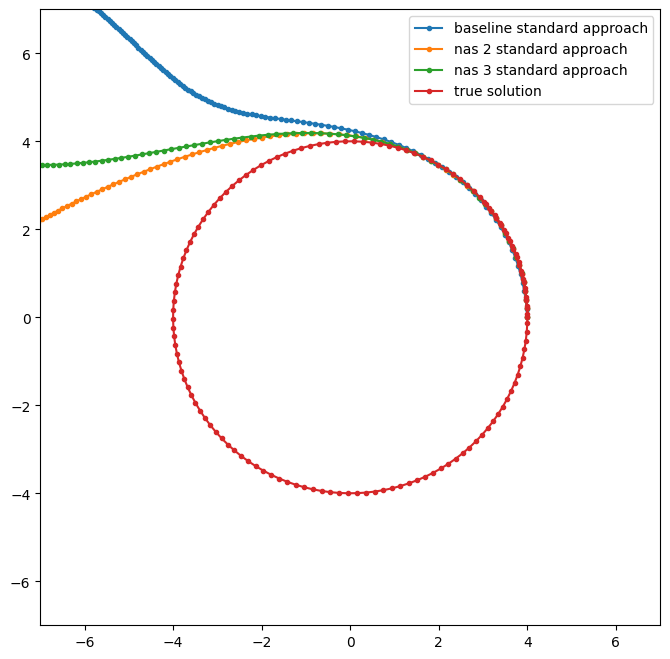

In [ ]:
y0 = [4., 0.]
max_t_pred = 7.
delta_t = 0.05

#validation_dac = predict_dac(model, y0, max_t_pred, delta_t)
validation_baseline_standard = predict_standard(pinn_baseline, y0, max_t_pred, delta_t)
validation_nas_2_standard = predict_standard(nas_2_layer_pinn, y0, max_t_pred, delta_t)
validation_nas_3_standard = predict_standard(nas_3_layer_pinn, y0, max_t_pred, delta_t)

true_solution = np.array([
    solution_simple_ODE(t, y0) 
    for t in np.linspace(0, max_t_pred, int(max_t_pred / delta_t) + 1)
])
fig, ax = generate_figure(figsize=(8,8), xlim=[-7, 7], ylim=[-7, 7])

ax = plot_ode_solution(ax, validation_baseline_standard, label="baseline standard approach")
ax = plot_ode_solution(ax, validation_nas_2_standard, label="nas 2 standard approach")
ax = plot_ode_solution(ax, validation_nas_3_standard, label="nas 3 standard approach")
ax = plot_ode_solution(ax, true_solution, label="true solution")

plt.legend()
plt.savefig("proof_of_concept.pdf", bbox_inches="tight")
plt.show()

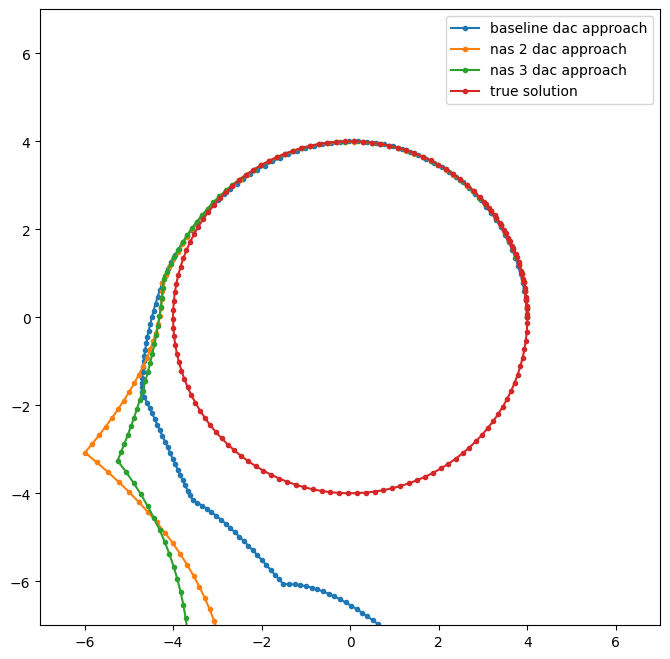

In [ ]:
y0 = [4., 0.]
max_t_pred = 7.
delta_t = 0.05

#validation_dac = predict_dac(model, y0, max_t_pred, delta_t)
validation_baseline_dac = predict_dac(pinn_baseline, y0, max_t_pred, delta_t)
validation_nas_2_dac = predict_dac(nas_2_layer_pinn, y0, max_t_pred, delta_t)
validation_nas_3_dac = predict_dac(nas_3_layer_pinn, y0, max_t_pred, delta_t)

true_solution = np.array([
    solution_simple_ODE(t, y0) 
    for t in np.linspace(0, max_t_pred, int(max_t_pred / delta_t) + 1)
])
fig, ax = generate_figure(figsize=(8,8), xlim=[-7, 7], ylim=[-7, 7])

ax = plot_ode_solution(ax, validation_baseline_dac, label="baseline dac approach")
ax = plot_ode_solution(ax, validation_nas_2_dac, label="nas 2 dac approach")
ax = plot_ode_solution(ax, validation_nas_3_dac, label="nas 3 dac approach")
ax = plot_ode_solution(ax, true_solution, label="true solution")

plt.legend()
plt.savefig("proof_of_concept.pdf", bbox_inches="tight")
plt.show()

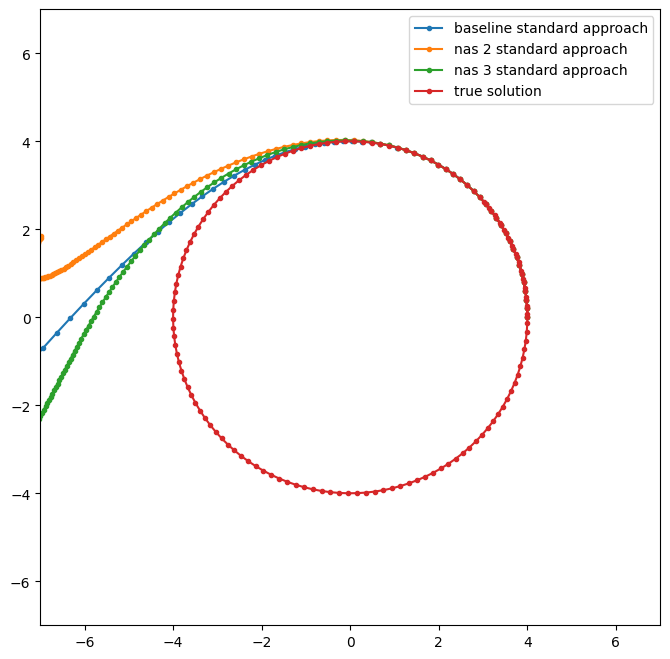

In [ ]:
y0 = [4., 0.]
max_t_pred = 7.
delta_t = 0.05

#validation_dac = predict_dac(model, y0, max_t_pred, delta_t)
validation_baseline_standard = predict_standard(pinn_baseline, y0, max_t_pred, delta_t)
validation_nas_2_standard = predict_standard(nas_2_layer_pinn, y0, max_t_pred, delta_t)
validation_nas_3_standard = predict_standard(nas_3_layer_pinn, y0, max_t_pred, delta_t)

true_solution = np.array([
    solution_simple_ODE(t, y0) 
    for t in np.linspace(0, max_t_pred, int(max_t_pred / delta_t) + 1)
])
fig, ax = generate_figure(figsize=(8,8), xlim=[-7, 7], ylim=[-7, 7])

ax = plot_ode_solution(ax, validation_baseline_standard, label="baseline standard approach")
ax = plot_ode_solution(ax, validation_nas_2_standard, label="nas 2 standard approach")
ax = plot_ode_solution(ax, validation_nas_3_standard, label="nas 3 standard approach")
ax = plot_ode_solution(ax, true_solution, label="true solution")

plt.legend()
plt.savefig("proof_of_concept.pdf", bbox_inches="tight")
plt.show()

In [ ]:
nas_2_layer_pinn = PINN(X_pinn, X_semigroup, 
                 X_smooth,T,nas_model_2_layer,False)
nas_3_layer_pinn = PINN(X_pinn, X_semigroup, 
                 X_smooth,T,nas_model_3_layer,False)
layers = [3, 20, 20, 20, 20, 2]
pinn_baseline = PINN_baseline(X_pinn, X_semigroup, 
                 X_smooth,T,nas_model_2_layer,layers,False)

In [ ]:
nas_3_layer_pinn.train()

In [ ]:
pinn_baseline.train()

In [ ]:
y0 = [4., 0.]
max_t_pred = 7.
delta_t = 0.05

#validation_dac = predict_dac(model, y0, max_t_pred, delta_t)
validation_baseline_standard = predict_standard(pinn_baseline, y0, max_t_pred, delta_t)
validation_nas_2_standard = predict_standard(nas_2_layer_pinn, y0, max_t_pred, delta_t)
validation_nas_3_standard = predict_standard(nas_3_layer_pinn, y0, max_t_pred, delta_t)

true_solution = np.array([
    solution_simple_ODE(t, y0) 
    for t in np.linspace(0, max_t_pred, int(max_t_pred / delta_t) + 1)
])
fig, ax = generate_figure(figsize=(8,8), xlim=[-7, 7], ylim=[-7, 7])

ax = plot_ode_solution(ax, validation_baseline_standard, label="baseline standard approach")
ax = plot_ode_solution(ax, validation_nas_2_standard, label="nas 2 standard approach")
ax = plot_ode_solution(ax, validation_nas_3_standard, label="nas 3 standard approach")
ax = plot_ode_solution(ax, true_solution, label="true solution")

plt.legend()
plt.savefig("proof_of_concept.pdf", bbox_inches="tight")
plt.show()

In [ ]:
y0 = [4., 0.]
max_t_pred = 7.
delta_t = 0.05

#validation_dac = predict_dac(model, y0, max_t_pred, delta_t)
validation_baseline_dac = predict_dac(pinn_baseline, y0, max_t_pred, delta_t)
validation_nas_2_dac = predict_dac(nas_2_layer_pinn, y0, max_t_pred, delta_t)
validation_nas_3_dac = predict_dac(nas_3_layer_pinn, y0, max_t_pred, delta_t)

true_solution = np.array([
    solution_simple_ODE(t, y0) 
    for t in np.linspace(0, max_t_pred, int(max_t_pred / delta_t) + 1)
])
fig, ax = generate_figure(figsize=(8,8), xlim=[-7, 7], ylim=[-7, 7])

ax = plot_ode_solution(ax, validation_baseline_dac, label="baseline dac approach")
ax = plot_ode_solution(ax, validation_nas_2_dac, label="nas 2 dac approach")
ax = plot_ode_solution(ax, validation_nas_3_dac, label="nas 3 dac approach")
ax = plot_ode_solution(ax, true_solution, label="true solution")

plt.legend()
plt.savefig("proof_of_concept.pdf", bbox_inches="tight")
plt.show()

In [ ]:
def evaluate_euclidean_distance(baseline,nas_model_1,
                                nas_model_2):
  N_evaluate = 1000
  y0s = np.random.uniform(0, max_y0, (N_evaluate,2))
  max_t_pred = 7.
  delta_t = 0.01
  baseline_standard_distances = []
  baseline_dac_distances = []
  nas_1_standard_distances = []
  nas_1_dac_distances = []
  nas_2_standard_distances = []
  nas_2_dac_distances = []
  standard_solutions = []
  dac_solutions = []
  models = [baseline,nas_model_1,nas_model_2]
  for i,model in enumerate(models):
    #baseline
    for y0 in y0s:
      standard_solution = predict_standard(model, y0, max_t_pred, delta_t)
      standard_solutions.append(standard_solution)
      true_solution = np.array([
        solution_simple_ODE(t, y0) 
        for t in np.linspace(0, max_t_pred, int(max_t_pred / delta_t) + 1)
      ])
    if i == 0:
      baseline_standard_distances.append(np.sqrt(np.sum((standard_solution - true_solution) ** 2, axis=1)))
    elif i == 1:
      nas_1_standard_distances.append(np.sqrt(np.sum((standard_solution - true_solution) ** 2, axis=1)))
    else:
      nas_2_standard_distances.append(np.sqrt(np.sum((standard_solution - true_solution) ** 2, axis=1)))
    #dac
    for y0 in y0s:
      dac_solution = predict_dac(model, y0, max_t_pred, delta_t)
      dac_solutions.append(dac_solution)
      true_solution = np.array([
        solution_simple_ODE(t, y0) 
        for t in np.linspace(0, max_t_pred, int(max_t_pred / delta_t) + 1)
      ])
    if i == 0:
      baseline_dac_distances.append(np.sqrt(np.sum((dac_solution - true_solution) ** 2, axis=1)))
    elif i == 1:
      nas_1_dac_distances.append(np.sqrt(np.sum((dac_solution - true_solution) ** 2, axis=1)))
    else:
      nas_2_dac_distances.append(np.sqrt(np.sum((dac_solution - true_solution) ** 2, axis=1)))
  #compute
  baseline_standard_avg_distance, baseline_standard_std_distance = np.mean(baseline_standard_distances),np.std(baseline_standard_distances)
  print('baseline standard average distance: ', baseline_standard_avg_distance, 'baseline standard std distance: ', baseline_standard_std_distance)
  baseline_dac_avg_distance, baseline_dac_std_distance = np.mean(baseline_dac_distances),np.std(baseline_dac_distances)
  print('baseline dac average distance: ', baseline_dac_avg_distance, 'baseline dac std distance: ', baseline_dac_std_distance)
  nas_1_standard_avg_distance, nas_1_standard_std_distance = np.mean(nas_1_standard_distances),np.std(nas_1_standard_distances)
  print('nas 2 layers standard average distance: ', nas_1_standard_avg_distance, 'nas 2 layers standard std distance: ', nas_1_standard_std_distance )
  nas_1_dac_avg_distance, nas_1_dac_std_distance = np.mean(nas_1_dac_distances),np.std(nas_1_dac_distances)
  print('nas 2 layers dac average distance: ', nas_1_dac_avg_distance, 'nas 2 layers dac std distance: ', nas_1_dac_std_distance )
  nas_2_standard_avg_distance, nas_2_standard_std_distance = np.mean(nas_2_standard_distances),np.std(nas_2_standard_distances)
  print('nas 3 layers standard average distance: ', nas_2_standard_avg_distance, 'nas 3 layers standard std distance: ', nas_2_standard_std_distance )
  nas_2_dac_avg_distance, nas_2_dac_std_distance = np.mean(nas_2_dac_distances),np.std(nas_2_dac_distances)
  print('nas 3 layers dac average distance: ', nas_2_dac_avg_distance, 'nas 3 layers dac std distance: ', nas_2_dac_std_distance )

In [ ]:
evaluate_euclidean_distance()

baseline standard average distance:  2.446637989188117 baseline standard std distance:  3.0920831222021326
baseline dac average distance:  0.6569662922257008 baseline dac std distance:  0.9070838123303362
nas 2 layers standard average distance:  1.2597409820546592 nas 2 layers standard std distance:  1.5179940673082037
nas 2 layers dac average distance:  1.0736418213277887 nas 2 layers dac std distance:  1.6556949671128662
nas 3 layers standard average distance:  1.2694360068980286 nas 3 layers standard std distance:  1.7365553060837449
nas 3 layers dac average distance:  0.9621870457661464 nas 3 layers dac std distance:  1.618209901148994


In [ ]:
ablation_nums = 5
for i in range(ablation_nums):
  nas_2_layer_pinn = PINN(X_pinn, X_semigroup, 
                 X_smooth,T,nas_model_2_layer,False)
  nas_3_layer_pinn = PINN(X_pinn, X_semigroup, 
                 X_smooth,T,nas_model_3_layer,False)
  layers = [3, 20, 20, 20, 20, 2]
  pinn_baseline = PINN_baseline(X_pinn, X_semigroup, 
                 X_smooth,T,nas_model_2_layer,layers,False)

  nas_2_layer_pinn.train()
  nas_3_layer_pinn.train()
  pinn_baseline.train()
  print("ablation experiment ", i)
  evaluate_euclidean_distance()

Iter 100, Loss: 0.00170, Loss_pinn: 0.00084 Loss_smooth: 0.00077, Loss_semigroup: 0.00008
Iter 200, Loss: 0.00028, Loss_pinn: 0.00014 Loss_smooth: 0.00011, Loss_semigroup: 0.00003
Iter 300, Loss: 0.00012, Loss_pinn: 0.00006 Loss_smooth: 0.00005, Loss_semigroup: 0.00001
Iter 400, Loss: 0.00007, Loss_pinn: 0.00003 Loss_smooth: 0.00003, Loss_semigroup: 0.00001
Iter 500, Loss: 0.00004, Loss_pinn: 0.00002 Loss_smooth: 0.00002, Loss_semigroup: 0.00000
Iter 600, Loss: 0.00002, Loss_pinn: 0.00001 Loss_smooth: 0.00001, Loss_semigroup: 0.00000
Iter 700, Loss: 0.00002, Loss_pinn: 0.00001 Loss_smooth: 0.00001, Loss_semigroup: 0.00000
Iter 800, Loss: 0.00001, Loss_pinn: 0.00001 Loss_smooth: 0.00001, Loss_semigroup: 0.00000
Iter 900, Loss: 0.00001, Loss_pinn: 0.00000 Loss_smooth: 0.00000, Loss_semigroup: 0.00000
Iter 1000, Loss: 0.00001, Loss_pinn: 0.00000 Loss_smooth: 0.00000, Loss_semigroup: 0.00000
Iter 1100, Loss: 0.00001, Loss_pinn: 0.00000 Loss_smooth: 0.00000, Loss_semigroup: 0.00000
Iter 120